# Jupyter Notebook-based user interface
## Importing the needed libraries


In [1]:
import rospy
import actionlib
from assignment_2_2023.msg import PlanningAction, PlanningGoal, PlanningFeedback, PlanningResult
from assignment_2_2023.msg import CustomMessage
from nav_msgs.msg import Odometry
import jupyros as jr
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from std_msgs.msg import String


## Node initialization

In [2]:
rospy.init_node('action_client_node', anonymous=True)

##  Declaration of pusblisher

In [3]:
client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)

client.wait_for_server()

custom_pub = rospy.Publisher('/custom_topic', CustomMessage, queue_size=10)

## Buttons for send and cancel Goal

In [4]:

x_widget = widgets.FloatText(description='Coordinate X:')
y_widget = widgets.FloatText(description='Coordinate Y:')
send_button = widgets.Button(description='Set Goal')
cancel_button = widgets.Button(description='Cancel Goal')

## Display the output

In [5]:
feedback_output = widgets.Output()

## Callback function for sending goal Buttons

In [6]:
def set_goal(x, y):
    goal = PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    client.send_goal(goal, done_cb=goal_done_callback)
    with feedback_output:
        print("Your goal is set (x={}, y={}).\n".format(x, y))
def goal_done_callback(status, result):
    with feedback_output:
        if status == actionlib.GoalStatus.SUCCEEDED:
            print(" Goal has been reached.\n")
            reached_x.append(x_widget.value)
            reached_y.append(y_widget.value)
        elif status == actionlib.GoalStatus.PREEMPTED:
            print("Goal preempted.\n")
            canceled_x.append(x_widget.value)
            canceled_y.append(y_widget.value)
        else:
            print("Goal failed.\n")
            canceled_x.append(x_widget.value)
            canceled_y.append(y_widget.value)

def send_button_clicked(b):
    set_goal(x_widget.value, y_widget.value)

def cancel_button_clicked(b):
    client.cancel_goal()
    canceled_x.append(x_widget.value)
    canceled_y.append(y_widget.value)
    with feedback_output:
            print("Goal has been canceled.\n")

send_button.on_click(send_button_clicked)
cancel_button.on_click(cancel_button_clicked)

## Plot of Robot Position and Plot for Reached and Cancelled Goals

<IPython.core.display.Javascript object>


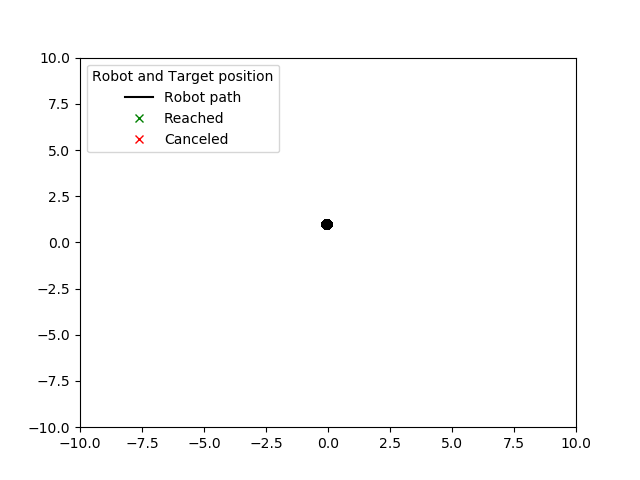

In [7]:
%matplotlib notebook
fig, ax = plt.subplots()
ln, = plt.plot([], [], 'ro')
x_data, y_data = [], []  
reached_x, reached_y = [], [] 
canceled_x, canceled_y = [], []  

handles = [
    Line2D([], [], color='black', label='Robot path', linestyle='-'),
    Line2D([], [], marker='x', markersize=6, color='green', markerfacecolor='green', linestyle='None', label='Reached'),
    Line2D([], [], marker='x', markersize=6, color='red', markerfacecolor='red', linestyle='None', label='Canceled'),
]

labels = [handle.get_label() for handle in handles]

def plot_init():
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    legend = plt.legend(handles, labels, loc='upper left')
    legend.set_title('Robot and Target position')
    return ln, legend


def update_plot(frame):
    ln.set_data(x_data, y_data)
    ln.set_color((0, 0, 0))  
    ln.set_linewidth(0.3)
    
    scatter_reached = plt.scatter(reached_x, reached_y, marker='x', color='green', zorder=2)
    scatter_canceled = plt.scatter(canceled_x, canceled_y, marker='x', color='red', zorder=1)
    
    ln.set_zorder(0)  
    return ln, scatter_reached, scatter_canceled

def odom_callback(odom_msg):
    x = odom_msg.pose.pose.position.x
    y = odom_msg.pose.pose.position.y
    vel_x = odom_msg.twist.twist.linear.x
    vel_z = odom_msg.twist.twist.angular.z

    custom_msg = CustomMessage()
    custom_msg.x = x
    custom_msg.y = y
    custom_msg.vel_x = vel_x
    custom_msg.vel_z = vel_z
    custom_pub.publish(custom_msg)
    
    x_data.append(x)
    y_data.append(y)

    

In [10]:
rospy.Subscriber('/odom', Odometry, odom_callback)
display(x_widget, y_widget, send_button, cancel_button, feedback_output)


ani = FuncAnimation(fig, update_plot, init_func=plot_init)
plt.show(block=True)

FloatText(value=0.0, description='Coordinate X:')

FloatText(value=0.0, description='Coordinate Y:')

Button(description='Set Goal', style=ButtonStyle())

Button(description='Cancel Goal', style=ButtonStyle())

Output()